In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Feature selection

## Method 1: Variance Thresholding

- We remove all features that have low variance. This is because features with low variance do not contain much information. We can use the `VarianceThreshold` class from `sklearn.feature_selection` to remove features with low variance.
- To see how what the variance threshold should be, we train a Decision Tree Classifier, a Random Forest Classifier and XGBoost Classifier on the training + testing data and plot the accuracy of the model against the variance threshold, after 5 fold cross validation. We do not do any nested cross validation, since there is no hyperparameter tuning involved. 

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def load_tsfel_dataset(base_dir, dataset_type):
    """
    Load dataset from the specified directory and encode labels.

    Parameters:
    - base_dir (str): Base directory containing the datasets.
    - dataset_type (str): Either 'Train' or 'Test'.

    Returns:
    - data (np.array): Numpy array with shape (num_subjects, num_timesteps, num_features).
    - labels_encoded (np.array): Encoded numerical labels for the data.
    """
    # Define the list of activity labels
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):  # Ensure we're only loading CSV files
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                # Assuming the columns represent the 3 accelerometer axes
                num_timesteps, num_features = df.shape
                
                # Convert the DataFrame to a numpy array with the shape (num_timesteps, num_features)
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    # Convert lists to numpy arrays
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels)  # Corresponding labels
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

Constant features: [  6   7  10  11  12  13  14  15  16  17  18  19 274 275 276 397 398 401
 402 403 404 405 406 407 408 409 410 788 789 792 793 794 795 796 797 798
 799 800 801]
Number of constant features removed: 39
Final dataset size after removing constant features: (180, 1134)


In [12]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost as xgb
# Define the base directory path
base_dir = 'Datasets/TSFEL_3axes_allfeatures'  # Update this with the actual path if different

# Load Train and Test datasets
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1) 
# Combine train and test datasets
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Assuming X_train_flat and X_test_flat are your original datasets

# Combine the training and test sets for consistent feature removal
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)

# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.0)
X_combined_reduced = selector.fit_transform(X_combined)

# Get the indices of the constant features
constant_features_idx = np.where(selector.variances_ == 0)[0]

# Print the constant features
print(f"Constant features: {constant_features_idx}")

# Number of features removed
num_features_removed = len(constant_features_idx)
print(f"Number of constant features removed: {num_features_removed}")

# Final dataset size
final_feature_count = X_combined_reduced.shape[1]
print(f"Final dataset size after removing constant features: {X_combined_reduced.shape}")

# Separate the reduced combined dataset back into training and test sets
X_train_flat = X_combined_reduced[:X_train_flat.shape[0], :]
X_test_flat = X_combined_reduced[X_train_flat.shape[0]:, :]



Constant features: [  6   7  10  11  12  13  14  15  16  17  18  19 274 275 276 397 398 401
 402 403 404 405 406 407 408 409 410 788 789 792 793 794 795 796 797 798
 799 800 801]
Number of constant features removed: 39
Final dataset size after removing constant features: (180, 1134)


With top 10 features:
X_train_flat_reduced shape: (126, 10)
X_test_flat_reduced shape: (54, 10)
Random Forest - Average CV Accuracy with 10 features: 0.8335
Decision Tree - Average CV Accuracy with 10 features: 0.8009
With top 20 features:
X_train_flat_reduced shape: (126, 20)
X_test_flat_reduced shape: (54, 20)
Random Forest - Average CV Accuracy with 20 features: 0.8649
Decision Tree - Average CV Accuracy with 20 features: 0.8166
With top 30 features:
X_train_flat_reduced shape: (126, 30)
X_test_flat_reduced shape: (54, 30)
Random Forest - Average CV Accuracy with 30 features: 0.8569
Decision Tree - Average CV Accuracy with 30 features: 0.7606
With top 40 features:
X_train_flat_reduced shape: (126, 40)
X_test_flat_reduced shape: (54, 40)
Random Forest - Average CV Accuracy with 40 features: 0.8726
Decision Tree - Average CV Accuracy with 40 features: 0.7929
With top 50 features:
X_train_flat_reduced shape: (126, 50)
X_test_flat_reduced shape: (54, 50)
Random Forest - Average CV Accur

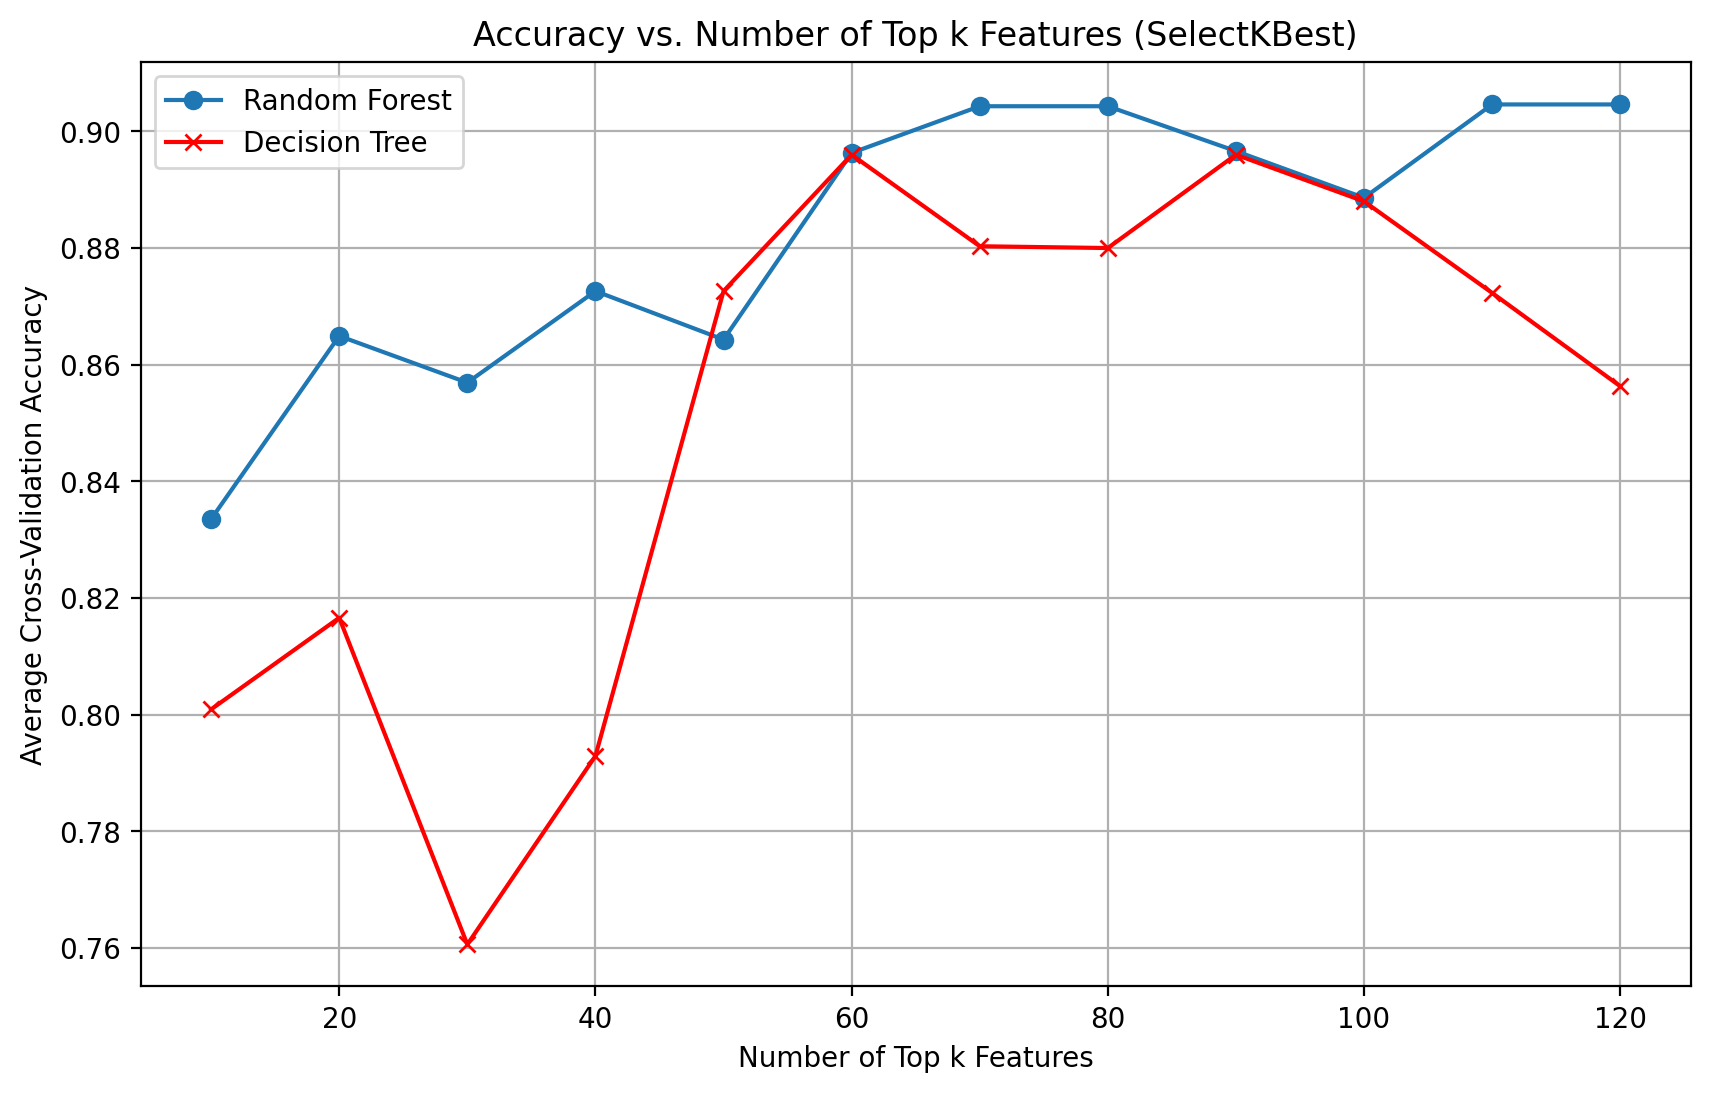

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define the range of k values (10 to 120)
k_values = np.arange(10, 121, 10)

# List to store average cross-validation accuracies
avg_accuracies_rf = []
avg_accuracies_dt = []

for k in k_values:
    # Select the top k features using SelectKBest
    selector = SelectKBest(f_classif, k=k)
    
    # Apply the selector to both training and testing data
    X_train_flat_reduced = selector.fit_transform(X_train_flat, y_train)
    X_test_flat_reduced = selector.transform(X_test_flat)
    
    # Print the shape of the reduced data (for verification)
    print(f"With top {k} features:")
    print(f"X_train_flat_reduced shape: {X_train_flat_reduced.shape}")
    print(f"X_test_flat_reduced shape: {X_test_flat_reduced.shape}")
    
    # Initialize and train the Random Forest Classifier
    clf_rf = RandomForestClassifier(n_estimators=300, random_state=42)
    
    # Perform 5-fold cross-validation for Random Forest
    cv_scores_rf = cross_val_score(clf_rf, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')
    
    # Calculate and store the average accuracy for Random Forest
    avg_accuracy_rf = np.mean(cv_scores_rf)
    avg_accuracies_rf.append(avg_accuracy_rf)
    
    print(f"Random Forest - Average CV Accuracy with {k} features: {avg_accuracy_rf:.4f}")
    
    # Initialize and train the Decision Tree Classifier
    clf_dt = DecisionTreeClassifier(random_state=42)
    
    # Perform 5-fold cross-validation for Decision Tree
    cv_scores_dt = cross_val_score(clf_dt, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')
    
    # Calculate and store the average accuracy for Decision Tree
    avg_accuracy_dt = np.mean(cv_scores_dt)
    avg_accuracies_dt.append(avg_accuracy_dt)
    
    print(f"Decision Tree - Average CV Accuracy with {k} features: {avg_accuracy_dt:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_accuracies_rf, marker='o', label='Random Forest')
plt.plot(k_values, avg_accuracies_dt, marker='x', label='Decision Tree', color='red')
plt.title('Accuracy vs. Number of Top k Features (SelectKBest)')
plt.xlabel('Number of Top k Features')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()


Threshold: 0.000 - Features: 1134 - Average CV Accuracy: 0.9222
Threshold: 0.010 - Features: 284 - Average CV Accuracy: 0.9111
Threshold: 0.020 - Features: 258 - Average CV Accuracy: 0.9111
Threshold: 0.030 - Features: 237 - Average CV Accuracy: 0.9167
Threshold: 0.040 - Features: 219 - Average CV Accuracy: 0.9167
Threshold: 0.050 - Features: 212 - Average CV Accuracy: 0.9167
Threshold: 0.060 - Features: 207 - Average CV Accuracy: 0.9056
Threshold: 0.070 - Features: 207 - Average CV Accuracy: 0.9056
Threshold: 0.080 - Features: 203 - Average CV Accuracy: 0.9167
Threshold: 0.090 - Features: 188 - Average CV Accuracy: 0.9056
Threshold: 0.100 - Features: 187 - Average CV Accuracy: 0.9111
Threshold: 0.110 - Features: 181 - Average CV Accuracy: 0.9111
Threshold: 0.120 - Features: 178 - Average CV Accuracy: 0.9056
Threshold: 0.130 - Features: 167 - Average CV Accuracy: 0.9056
Threshold: 0.140 - Features: 166 - Average CV Accuracy: 0.9000
Threshold: 0.150 - Features: 166 - Average CV Accuracy

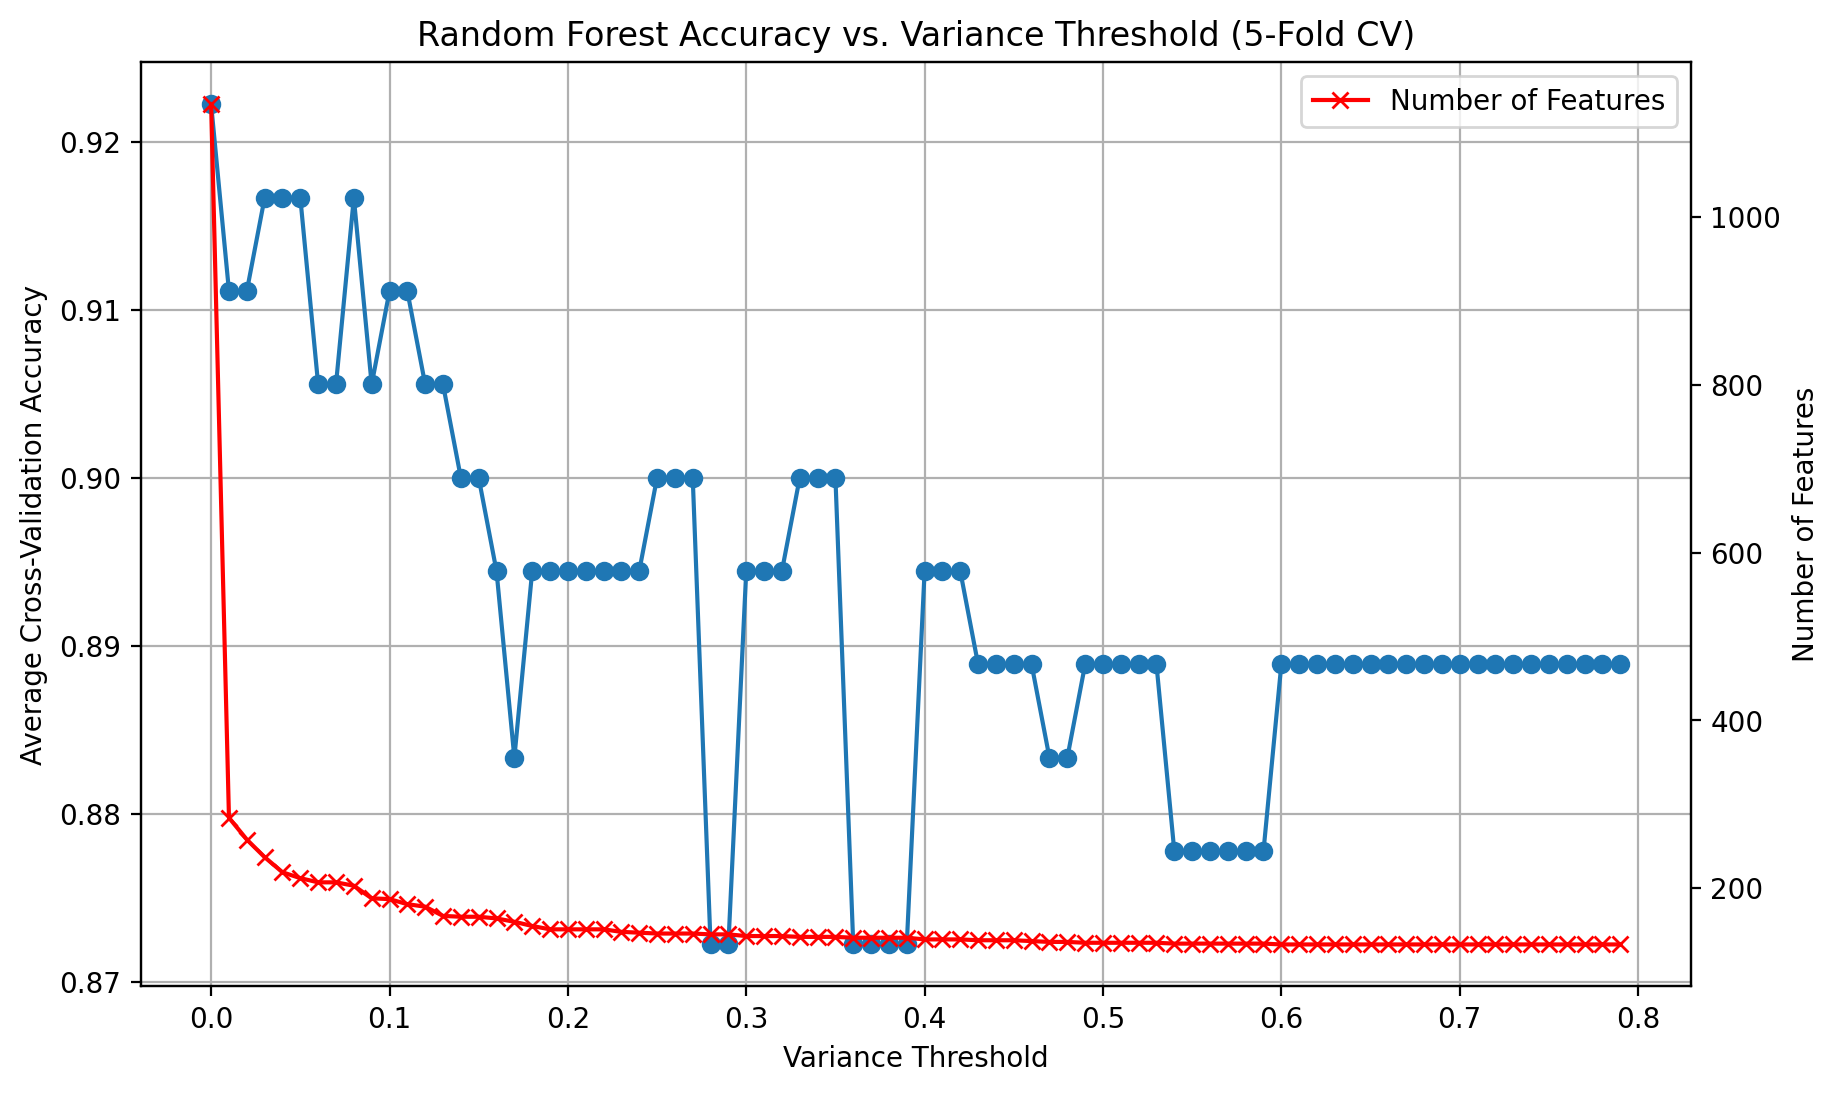

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Combine train and test datasets
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Define a range of variance thresholds to test
variance_thresholds = np.arange(0.00, 0.8, 0.01)

# List to store average cross-validation accuracies
avg_accuracies = []
num_features_list = []

# Define the 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Iterate over the variance thresholds
for threshold in variance_thresholds:
    # Apply variance thresholding
    variance_selector = VarianceThreshold(threshold=threshold)
    X_combined_reduced = variance_selector.fit_transform(X_combined)
    
    # Store the number of features after thresholding
    num_features = X_combined_reduced.shape[1]
    num_features_list.append(num_features)
    
    # Initialize the Random Forest classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=0)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_combined_reduced, y_combined, cv=kf, scoring='accuracy')
    
    # Calculate and store the average accuracy
    avg_accuracy = np.mean(cv_scores)
    avg_accuracies.append(avg_accuracy)
    
    print(f"Threshold: {threshold:.3f} - Features: {num_features} - Average CV Accuracy: {avg_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(variance_thresholds, avg_accuracies, marker='o')
plt.title('Random Forest Accuracy vs. Variance Threshold (5-Fold CV)')
plt.xlabel('Variance Threshold')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)

# Optionally, you can plot the number of features on a secondary y-axis
plt.twinx()
plt.plot(variance_thresholds, num_features_list, marker='x', color='red', label='Number of Features')
plt.ylabel('Number of Features')
plt.legend(loc='upper right')

plt.show()


Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 50.00%, Test Accuracy: 16.67%
Depth: 3, Train Accuracy: 66.67%, Test Accuracy: 16.67%
Depth: 4, Train Accuracy: 100.00%, Test Accuracy: 16.67%
Depth: 5, Train Accuracy: 100.00%, Test Accuracy: 16.67%
Depth: 6, Train Accuracy: 100.00%, Test Accuracy: 16.67%
Depth: 7, Train Accuracy: 100.00%, Test Accuracy: 16.67%
Depth: 8, Train Accuracy: 100.00%, Test Accuracy: 16.67%


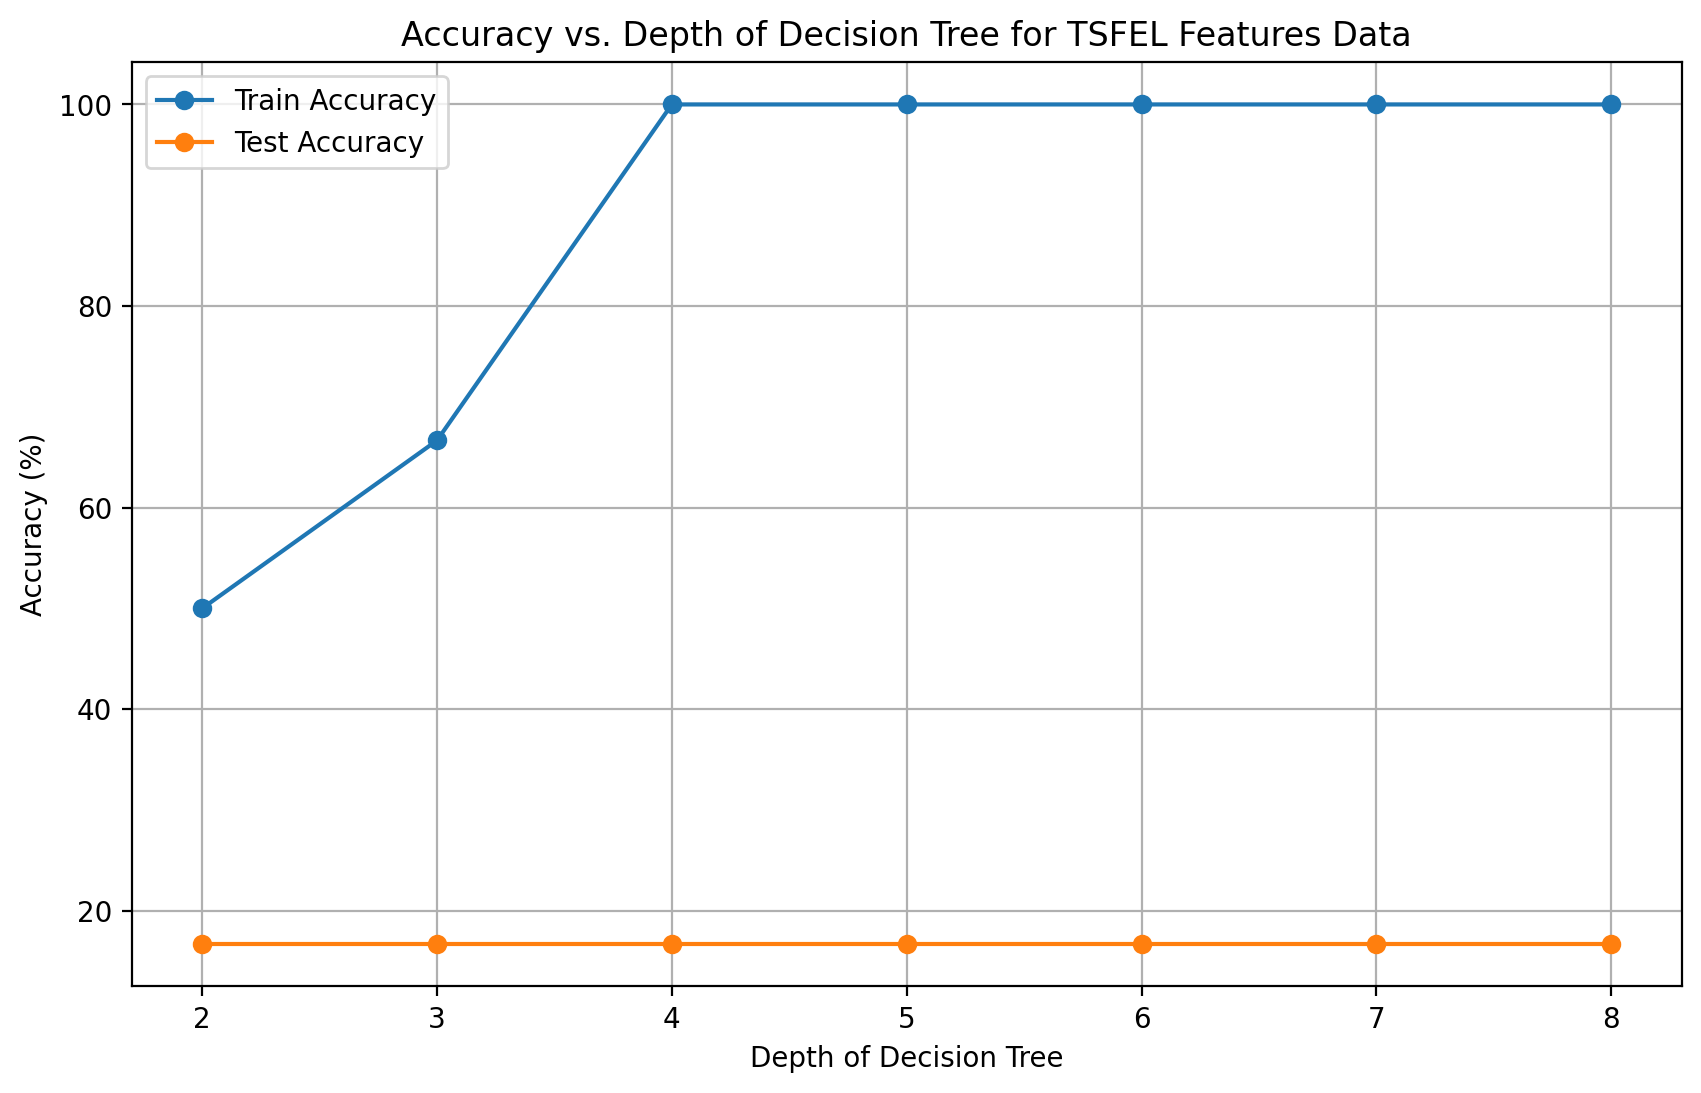

In [5]:

# Define a range of variance thresholds to test
variance_thresholds = np.arange(0.00, 0.8, 0.01)

# List to store average cross-validation accuracies and number of features
avg_accuracies = []
num_features_list = []

# Define the 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Iterate over the variance thresholds
for threshold in variance_thresholds:
    # Apply variance thresholding
    variance_selector = VarianceThreshold(threshold=threshold)
    X_combined_reduced = variance_selector.fit_transform(X_combined)
    
    # Store the number of features after thresholding
    num_features = X_combined_reduced.shape[1]
    num_features_list.append(num_features)
    
    # Initialize the XGBoost classifier
    clf = xgb.XGBClassifier(eval_metric='mlogloss', random_state=0)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_combined_reduced, y_combined, cv=kf, scoring='accuracy')
    
    # Calculate and store the average accuracy
    avg_accuracy = np.mean(cv_scores)
    avg_accuracies.append(avg_accuracy)
    
    print(f"Threshold: {threshold:.3f} - Features: {num_features} - Average CV Accuracy: {avg_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(variance_thresholds, avg_accuracies, marker='o')
plt.title('XGBoost Accuracy vs. Variance Threshold (5-Fold CV)')
plt.xlabel('Variance Threshold')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)

# Optionally, you can plot the number of features on a secondary y-axis
plt.twinx()
plt.plot(variance_thresholds, num_features_list, marker='x', color='red', label='Number of Features')
plt.ylabel('Number of Features')
plt.legend(loc='upper right')

plt.show()


Threshold: 0.000 - Features: 27 - Average CV Accuracy: 0.7556
Threshold: 0.010 - Features: 9 - Average CV Accuracy: 0.8111
Threshold: 0.020 - Features: 9 - Average CV Accuracy: 0.8111
Threshold: 0.030 - Features: 9 - Average CV Accuracy: 0.8111
Threshold: 0.040 - Features: 8 - Average CV Accuracy: 0.7944
Threshold: 0.050 - Features: 8 - Average CV Accuracy: 0.7944
Threshold: 0.060 - Features: 7 - Average CV Accuracy: 0.8111
Threshold: 0.070 - Features: 7 - Average CV Accuracy: 0.8111
Threshold: 0.080 - Features: 7 - Average CV Accuracy: 0.8111
Threshold: 0.090 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.100 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.110 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.120 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.130 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.140 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.150 - Features: 6 - Average CV Accuracy: 0.8167
Threshold: 0.160 - Feat

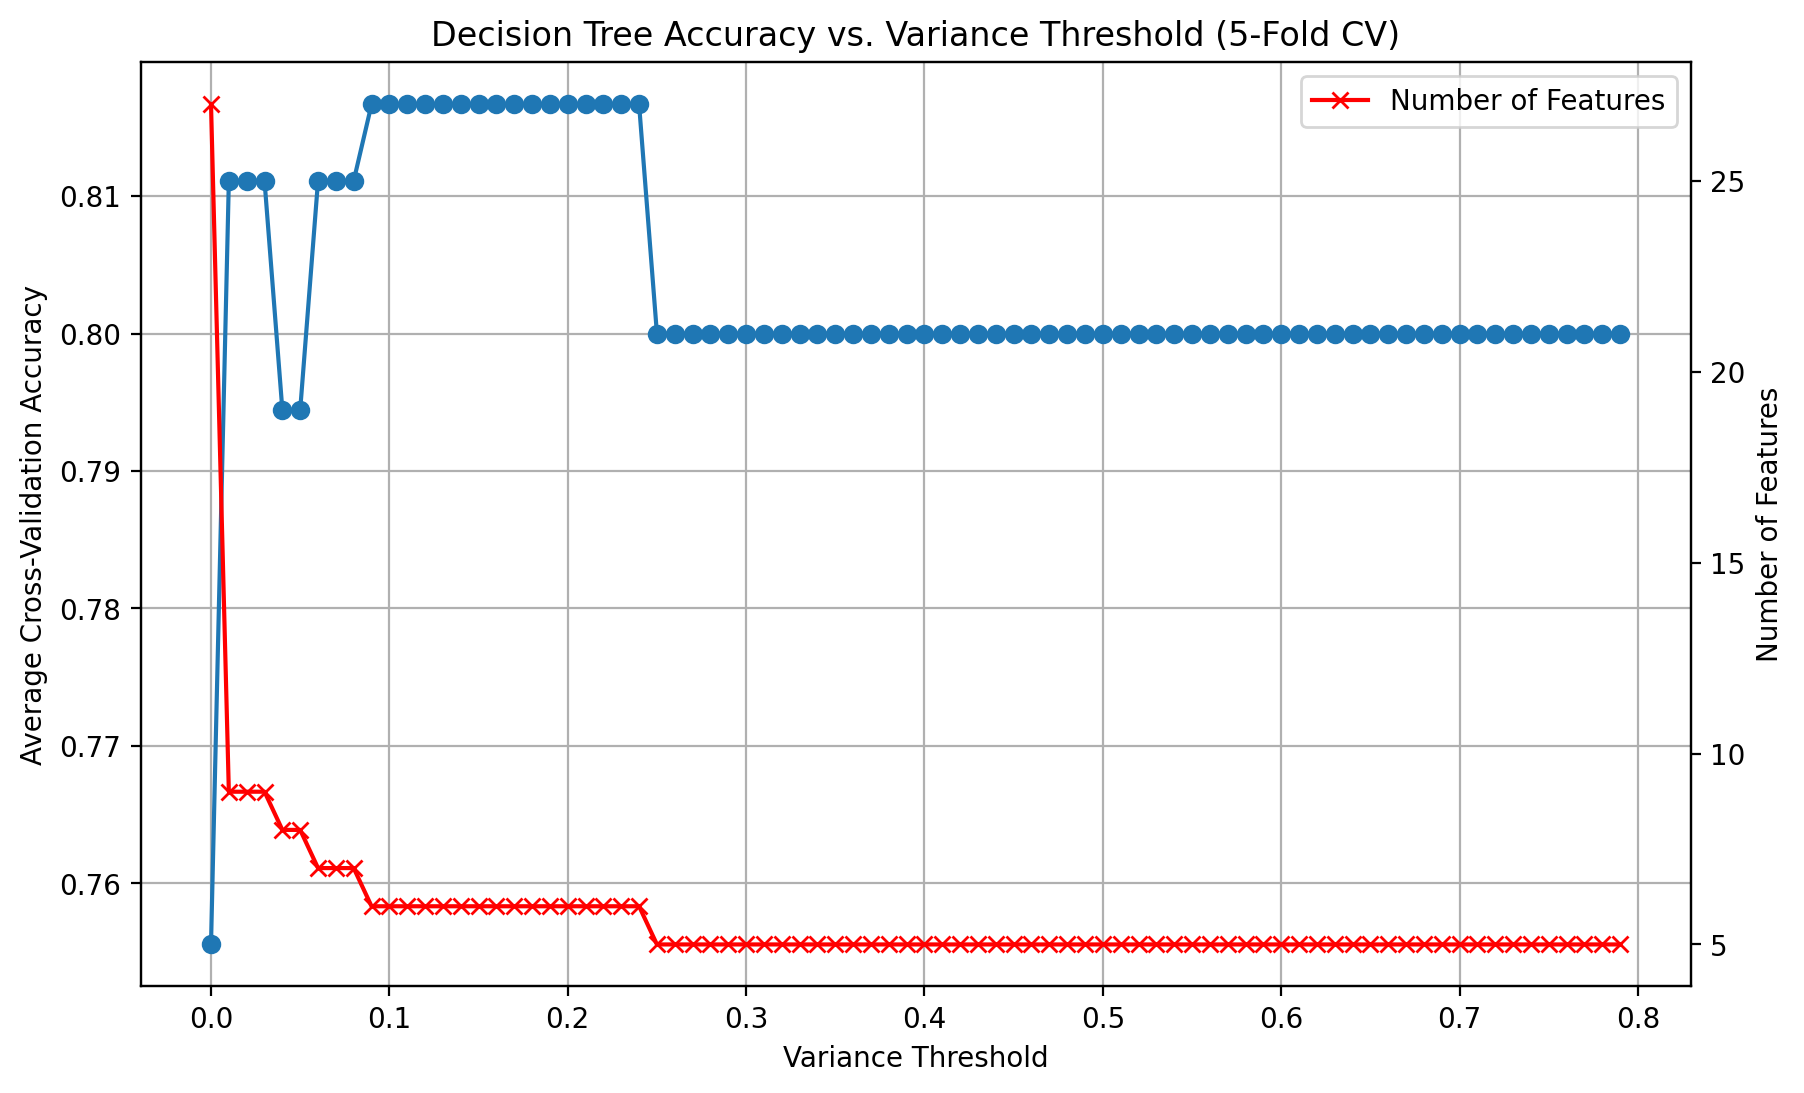

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Combine train and test datasets
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Define a range of variance thresholds to test
variance_thresholds = np.arange(0.00, 0.8, 0.01)

# List to store average cross-validation accuracies
avg_accuracies = []
num_features_list = []

# Define the 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Iterate over the variance thresholds
for threshold in variance_thresholds:
    # Apply variance thresholding
    variance_selector = VarianceThreshold(threshold=threshold)
    X_combined_reduced = variance_selector.fit_transform(X_combined)
    
    # Store the number of features after thresholding
    num_features = X_combined_reduced.shape[1]
    num_features_list.append(num_features)
    
    # Initialize the Decision Tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_combined_reduced, y_combined, cv=kf, scoring='accuracy')
    
    # Calculate and store the average accuracy
    avg_accuracy = np.mean(cv_scores)
    avg_accuracies.append(avg_accuracy)
    
    print(f"Threshold: {threshold:.3f} - Features: {num_features} - Average CV Accuracy: {avg_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(variance_thresholds, avg_accuracies, marker='o')
plt.title('Decision Tree Accuracy vs. Variance Threshold (5-Fold CV)')
plt.xlabel('Variance Threshold')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)

# Optionally, you can plot the number of features on a secondary y-axis
plt.twinx()
plt.plot(variance_thresholds, num_features_list, marker='x', color='red', label='Number of Features')
plt.ylabel('Number of Features')
plt.legend(loc='upper right')

plt.show()


In [7]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
n_components = 100  # Adjust this value based on your specific dataset
pca = PCA(n_components=n_components)

X_train_flat_reduced = pca.fit_transform(X_train_flat)
X_test_flat_reduced = pca.transform(X_test_flat)

print(f"X_train_flat_reduced shape: {X_train_flat_reduced.shape}")
print(f"X_test_flat_reduced shape: {X_test_flat_reduced.shape}")


ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=27 with svd_solver='full'

k = 10 - Average CV Accuracy: 0.8723
k = 12 - Average CV Accuracy: 0.8803
k = 14 - Average CV Accuracy: 0.8803
k = 16 - Average CV Accuracy: 0.8883
k = 18 - Average CV Accuracy: 0.8963
k = 20 - Average CV Accuracy: 0.8963
k = 22 - Average CV Accuracy: 0.8886
k = 24 - Average CV Accuracy: 0.9043
k = 26 - Average CV Accuracy: 0.9043
k = 28 - Average CV Accuracy: 0.9043
k = 30 - Average CV Accuracy: 0.9283
k = 32 - Average CV Accuracy: 0.9206
k = 34 - Average CV Accuracy: 0.9206
k = 36 - Average CV Accuracy: 0.9126
k = 38 - Average CV Accuracy: 0.9126
k = 40 - Average CV Accuracy: 0.9206
k = 42 - Average CV Accuracy: 0.9126
k = 44 - Average CV Accuracy: 0.9126
k = 46 - Average CV Accuracy: 0.9126
k = 48 - Average CV Accuracy: 0.9126
k = 50 - Average CV Accuracy: 0.9206
k = 52 - Average CV Accuracy: 0.9206
k = 54 - Average CV Accuracy: 0.9206
k = 56 - Average CV Accuracy: 0.9126
k = 58 - Average CV Accuracy: 0.9206
k = 60 - Average CV Accuracy: 0.9206
k = 62 - Average CV Accuracy: 0.9206
k

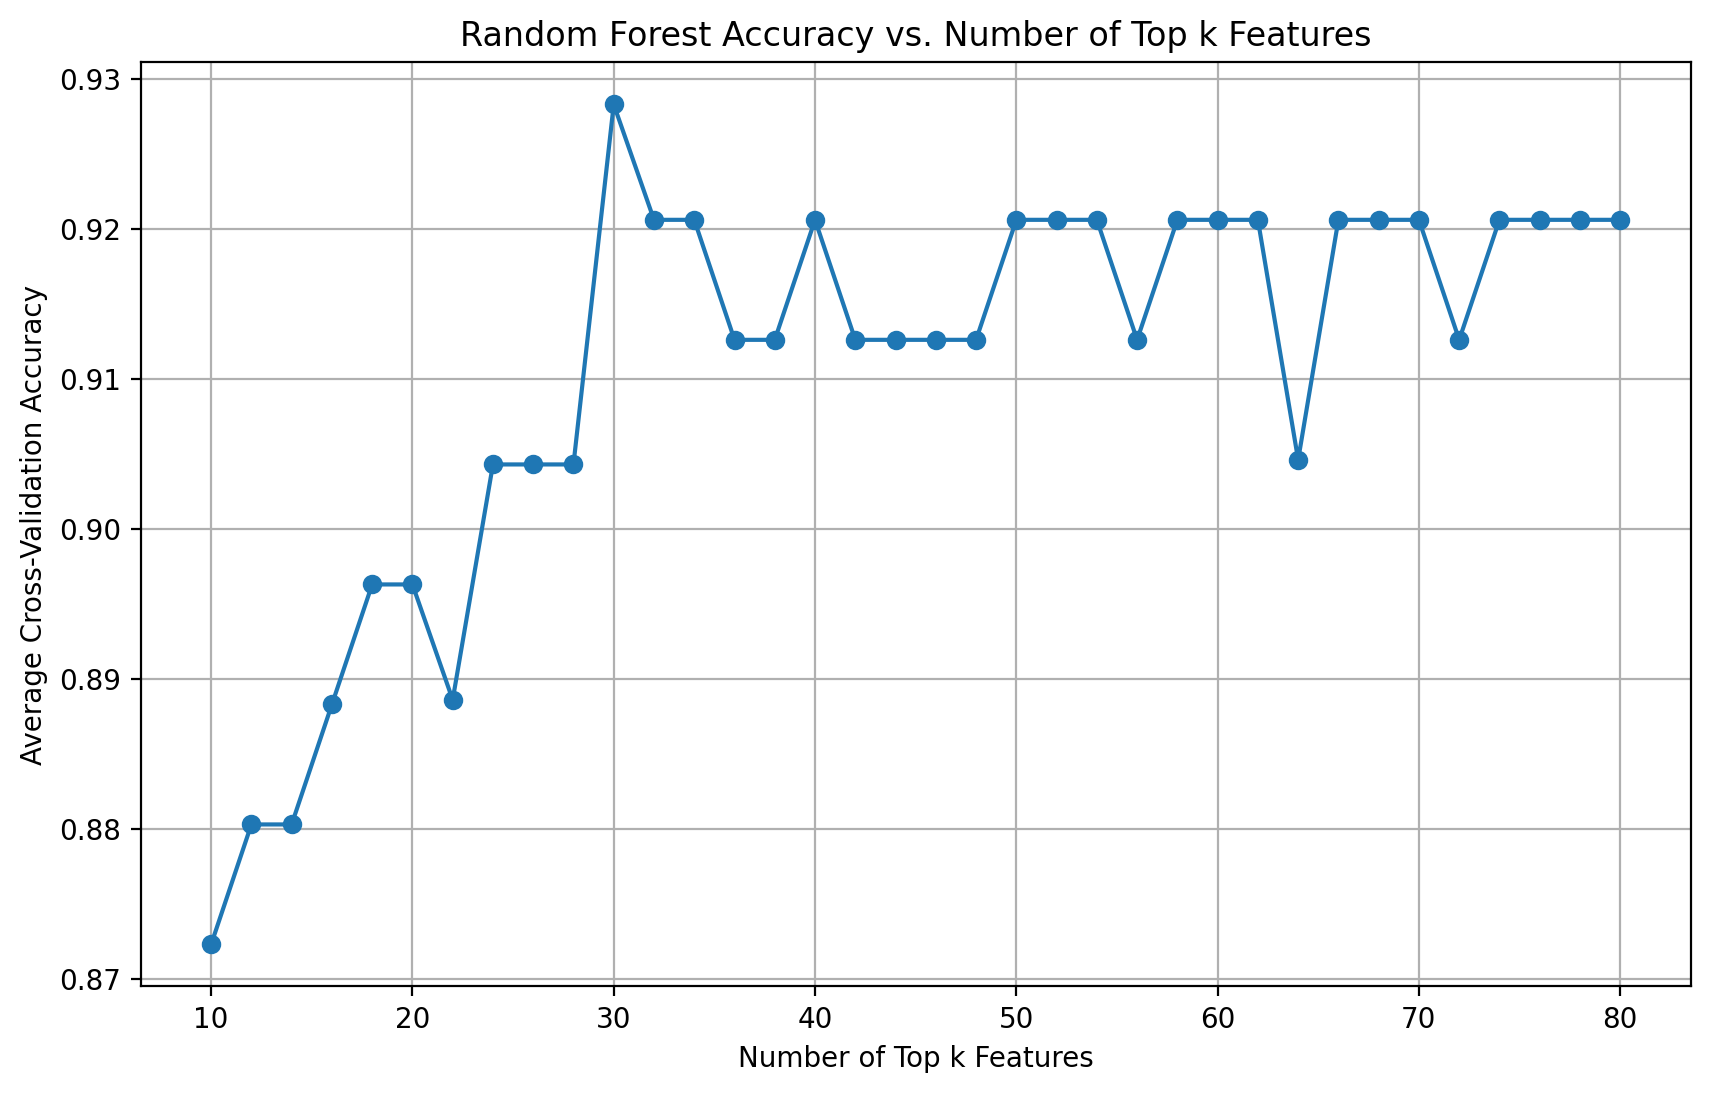

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Train a RandomForestClassifier to compute feature importances on the full dataset
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X_train_flat, y_train)

# Get feature importances and sort them in descending order
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Define the range of k values (10 to 50 in steps of 2)
k_values = np.arange(10, 81, 2)

# List to store average cross-validation accuracies
avg_accuracies = []

# Perform cross-validation for each value of k
for k in k_values:
    # Select the top k features based on the feature importance ranking
    top_k_indices = indices[:k]
    
    # Reduce the dataset to the top k features
    X_train_flat_reduced = X_train_flat[:, top_k_indices]
    X_test_flat_reduced = X_test_flat[:, top_k_indices]
    
    # Initialize a new RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=300, random_state=42)
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(clf, X_train_flat_reduced, y_train, cv=5, scoring='accuracy')
    
    # Calculate and store the average accuracy
    avg_accuracy = np.mean(cv_scores)
    avg_accuracies.append(avg_accuracy)
    
    print(f"k = {k} - Average CV Accuracy: {avg_accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, avg_accuracies, marker='o')
plt.title('Random Forest Accuracy vs. Number of Top k Features')
plt.xlabel('Number of Top k Features')
plt.ylabel('Average Cross-Validation Accuracy')
plt.grid(True)
plt.show()


k = 10 - Accuracy: 0.8704
k = 12 - Accuracy: 0.8704
k = 14 - Accuracy: 0.8704
k = 16 - Accuracy: 0.8889
k = 18 - Accuracy: 0.8704
k = 20 - Accuracy: 0.8889
k = 22 - Accuracy: 0.8704
k = 24 - Accuracy: 0.8704


k = 26 - Accuracy: 0.8889
k = 28 - Accuracy: 0.8704
k = 30 - Accuracy: 0.8704
k = 32 - Accuracy: 0.8889
k = 34 - Accuracy: 0.8704
k = 36 - Accuracy: 0.8889
k = 38 - Accuracy: 0.8704
k = 40 - Accuracy: 0.8704
k = 42 - Accuracy: 0.8704
k = 44 - Accuracy: 0.9074
k = 46 - Accuracy: 0.8704
k = 48 - Accuracy: 0.8889
k = 50 - Accuracy: 0.8889
k = 52 - Accuracy: 0.8889
k = 54 - Accuracy: 0.9074
k = 56 - Accuracy: 0.9259
k = 58 - Accuracy: 0.9074
k = 60 - Accuracy: 0.9074
k = 62 - Accuracy: 0.8889
k = 64 - Accuracy: 0.9074
k = 66 - Accuracy: 0.9074
k = 68 - Accuracy: 0.9074
k = 70 - Accuracy: 0.9074
k = 72 - Accuracy: 0.9074
k = 74 - Accuracy: 0.9074
k = 76 - Accuracy: 0.9074
k = 78 - Accuracy: 0.9074
k = 80 - Accuracy: 0.9074


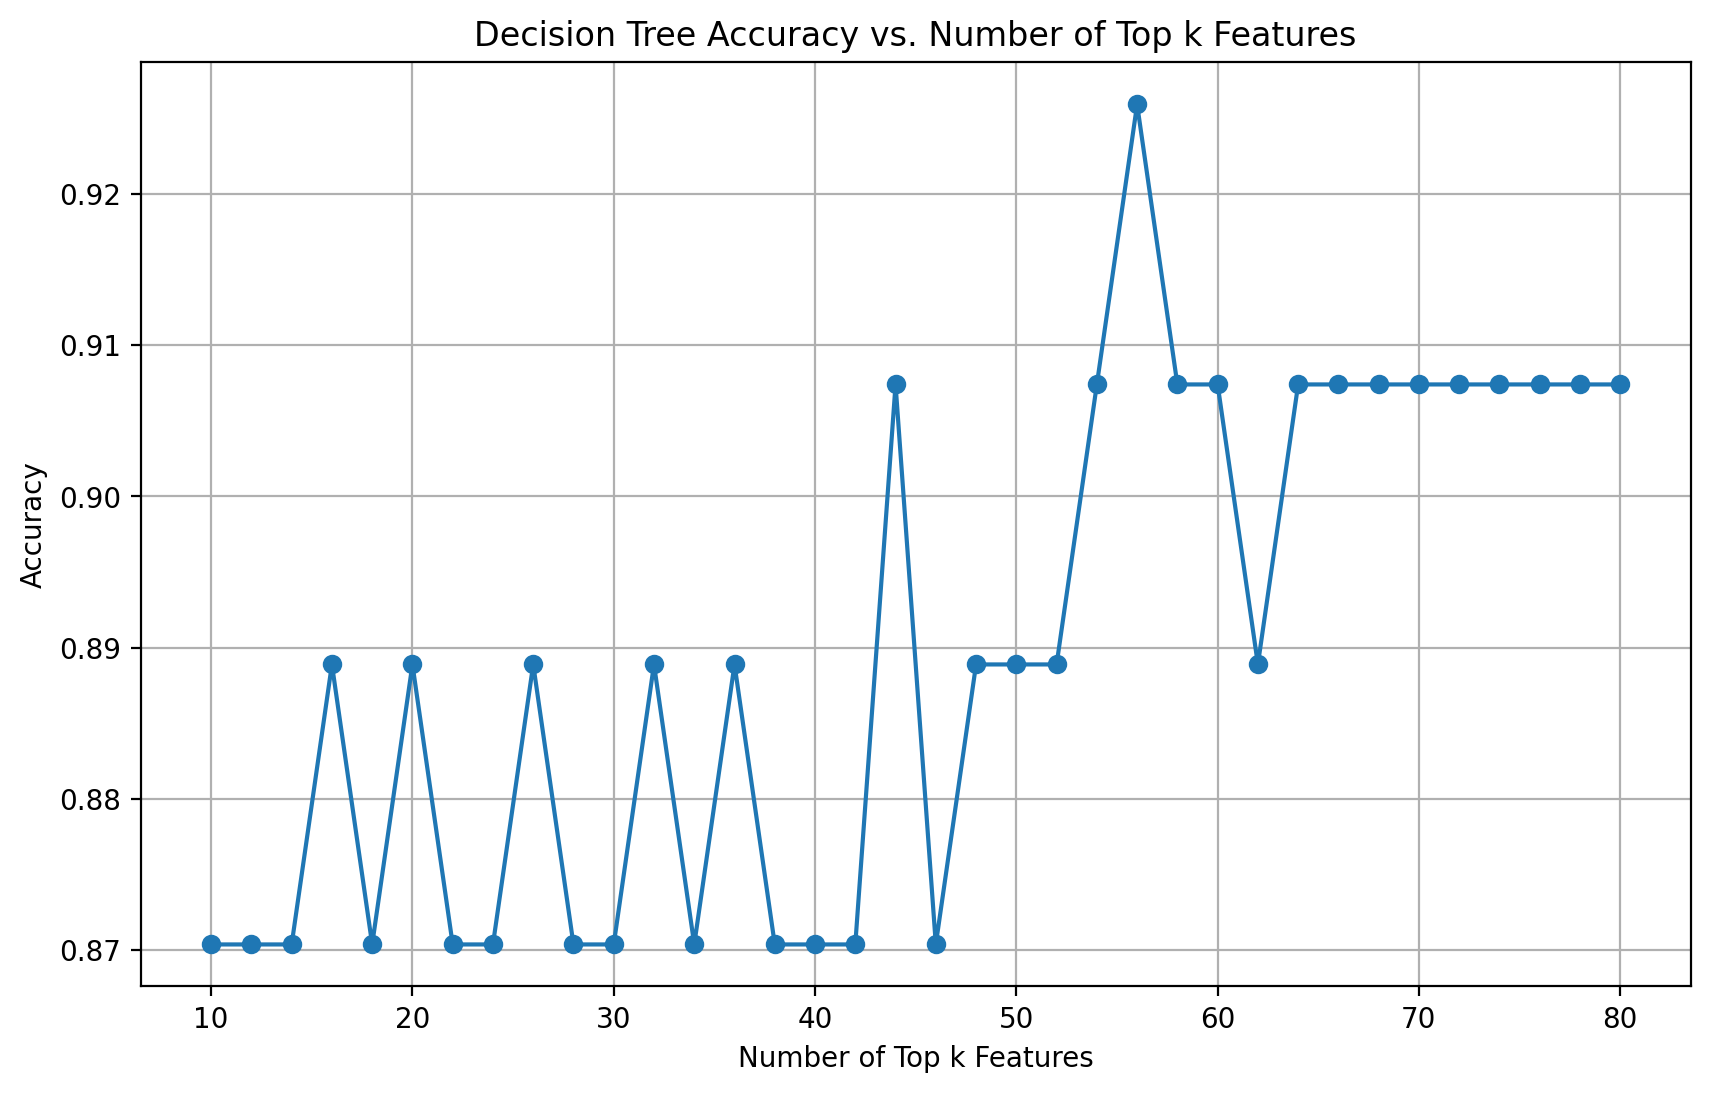

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assume the RandomForestClassifier was already trained and feature importances calculated
# Range of k values (10 to 60 in steps of 2)
k_values = np.arange(10, 81, 2)

# List to store accuracies
accuracies = []

for k in k_values:
    # Select the top k features based on the feature importance ranking
    top_k_indices = indices[:k]
    
    # Reduce the dataset to the top k features
    X_train_flat_reduced = X_train_flat[:, top_k_indices]
    X_test_flat_reduced = X_test_flat[:, top_k_indices]
    
    # Initialize and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_flat_reduced, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test_flat_reduced)
    
    # Calculate and store the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    print(f"k = {k} - Accuracy: {accuracy:.4f}")

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Decision Tree Accuracy vs. Number of Top k Features')
plt.xlabel('Number of Top k Features')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select the top k features
k = 100  # Adjust this value based on your specific dataset
selector = SelectKBest(f_classif, k=k)

X_train_flat_reduced = selector.fit_transform(X_train_flat, y_train)
X_test_flat_reduced = selector.transform(X_test_flat)

print(f"X_train_flat_reduced shape: {X_train_flat_reduced.shape}")
print(f"X_test_flat_reduced shape: {X_test_flat_reduced.shape}")


X_train_flat_reduced shape: (126, 100)
X_test_flat_reduced shape: (54, 100)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


With top 10 features:
X_train_flat_reduced shape: (126, 10)
X_test_flat_reduced shape: (54, 10)
Average CV Accuracy with 10 features: 0.8335
With top 20 features:
X_train_flat_reduced shape: (126, 20)
X_test_flat_reduced shape: (54, 20)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Average CV Accuracy with 20 features: 0.8649
With top 30 features:
X_train_flat_reduced shape: (126, 30)
X_test_flat_reduced shape: (54, 30)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Average CV Accuracy with 30 features: 0.8569
With top 40 features:
X_train_flat_reduced shape: (126, 40)
X_test_flat_reduced shape: (54, 40)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Average CV Accuracy with 40 features: 0.8726
With top 50 features:
X_train_flat_reduced shape: (126, 50)
X_test_flat_reduced shape: (54, 50)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Average CV Accuracy with 50 features: 0.8643
With top 60 features:
X_train_flat_reduced shape: (126, 60)
X_test_flat_reduced shape: (54, 60)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Average CV Accuracy with 60 features: 0.8963
With top 70 features:
X_train_flat_reduced shape: (126, 70)
X_test_flat_reduced shape: (54, 70)


c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  6   7 274 275 276 397 398 788 789] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\yashk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
